##### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style = 'darkgrid', font_scale = 1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from scipy import stats
from time import time

##### Load data

In [2]:
# Load data
file_path = 'data_breast_cancer.csv'
data = pd.read_csv(file_path, index_col = 'id').reset_index(drop = True)
data.drop('Unnamed: 32', axis = 1, inplace = True)

# Preview data
print('Dataframe shape', data.shape)
data.head(5)

Dataframe shape (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


##### Pre-process data

In [3]:
# Features and labels
X = data.drop('diagnosis', axis = 1)
y = data['diagnosis']

# Encode target to binary
y = (y == 'M').astype('int')

##### Split data

In [10]:
# Split dataset into training and testing data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

##### Iris flower dataset

In [5]:
# from sklearn import datasets, neighbors

# np.random.seed(7)
# iris_data = datasets.load_iris()
# iris_X = iris_data.data
# iris_y = iris_data.target
# print('Labels :',np.unique(iris_y))

# # split train and test
# X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size = 130)
# print(f'Train size : {X_train.shape[0]}, test_size : {X_test.shape[0]}')

##### The Algorithms

In [6]:
# KNeighborsClassifier with euclidean
def uniform(dist):
    return 1

def custom_distance(dist):
    sigma2 = .4
    return 1/(sigma2 + dist)

class KNN():
    def __init__(self, n_neighbors = 3, weights = uniform):
        self.k = n_neighbors
        self.weight = weights
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def dist_ss_fast(self, Z, X):
        X2 = np.sum(X * X, axis = 1)
        Z2 = np.sum(Z * Z, axis = 1)
        return Z2.reshape(-1,1) + X2.reshape(1,-1) - 2*(Z @ X.T)
    
    def get_neighbors(self, distance):
        n_labels = np.unique(y_train).shape[0]
        voting = np.zeros(shape = n_labels)
        pair_dis_label = list(zip(distance, self.y_train))
        pair_dis_label.sort()
        for i in range(self.k):
            voting[pair_dis_label[i][1]] += self.weight(pair_dis_label[i][0])
        return np.argmax(voting)
        
    def predict(self, X_test):
        N = X_test.shape[0]
        dist = self.dist_ss_fast(X_test, self.X_train)
        preds = np.zeros(shape = N, dtype = int)
        for i in range(N):
            majority = self.get_neighbors(dist[i])
            preds[i] = majority
        return preds

In [11]:
def accuracy(y_test, y_pred):
    return (y_test == y_pred).mean()

model = KNN(n_neighbors = 5, weights = custom_distance)
model.fit(X_train.values, y_train.values)


begin = time()
y_pred = model.predict(X_test.values)
print(f"Accuracy score: {accuracy(y_test, y_pred)*100:.3f} %")
print(f"Runtime: {time() - begin} s")

Accuracy score: 92.105 %
Runtime: 0.12759113311767578 s


##### Compare to sklearn

In [12]:
from sklearn.metrics import accuracy_score
import sklearn.neighbors

clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 5, p = 2, weights = custom_distance)
clf.fit(X_train, y_train)

begin = time()
y_pred_skl = clf.predict(X_test)
print(f'Sklearn accuracy: {accuracy_score(y_test, y_pred)*100:.3f} %')
print(f"Runtime: {time() - begin} s")

Sklearn accuracy: 92.105 %
Runtime: 0.18902325630187988 s


##### Experiments

Effect of k on accuracy

Text(0, 0.5, 'Runtime (second)')

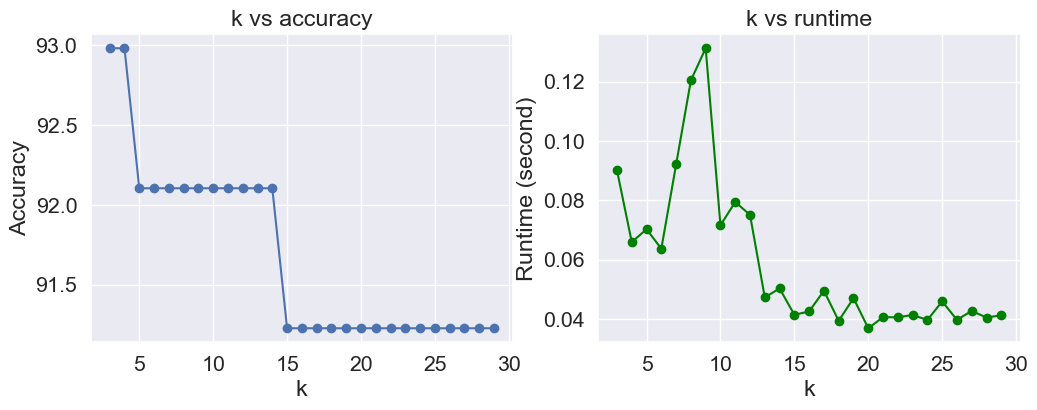

In [13]:
k_max = 30
accuracies = []
runtime = []

for i in range(3,k_max):
    model = KNN(n_neighbors = i, weights = custom_distance)
    model.fit(X_train.values , y_train.values)
    
    begin_iNN = time()
    y_pred_iNN = model.predict(X_test.values)
    runtime.append(time() - begin_iNN)
    accuracy_iNN = accuracy(y_test, y_pred_iNN)
    accuracies.append(accuracy_iNN*100)
    
list_k = [i for i in range(3,k_max)]

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.title('k vs accuracy')
plt.plot(list_k, accuracies, marker = 'o')
plt.xlabel('k')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('k vs runtime')
plt.plot(list_k, runtime, marker = 'o', color = 'green')
plt.xlabel('k')
plt.ylabel('Runtime (second)')